In [54]:
import os

OUTPUT_DIR = './'
MODEL_DIR = '../input/C://Users//kenso//OneDrive//Documents//cassava/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
TRAIN_PATH = 'C:/Users/kenso/OneDrive/Documents/cassava/train_images'
TEST_PATH = 'C:/Users/kenso/OneDrive/Documents/cassava/test_images'

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import json
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

In [56]:
os.chdir('C:\\Users\\kenso\\OneDrive\\Documents\\cassava')

In [57]:
#os.listdir('../input/C:/Users/kenso/OneDrive/Documents/cassava')

In [58]:
os.listdir('C:\\Users\\kenso\\OneDrive\\Documents\\cassava\\test_images')

['2216849948.jpg']

In [59]:
def preprocess(img):
    h,w = 224,224
    img = cv2.resize(img, (h,w))
    img = img.reshape(1,h,w,3)/255.
    return img

In [60]:
train_df = pd.read_csv('C:/Users/kenso/OneDrive/Documents/cassava/train.csv')
# test_df = pd.read_csv('../input/cassava-leaf-disease-classification/')
file = open('C:/Users/kenso/OneDrive/Documents/cassava/label_num_to_disease_map.json', "r")
with open('C:/Users/kenso/OneDrive/Documents/cassava/label_num_to_disease_map.json', "r") as f:
    label_names = json.loads(f.read())
    print(label_names)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [61]:
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [62]:
train_df.label = train_df.label.astype("str")

Cassava Bacterial Blight (CBB)


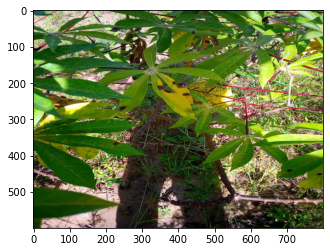

Cassava Mosaic Disease (CMD)


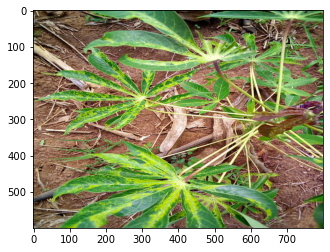

Cassava Brown Streak Disease (CBSD)


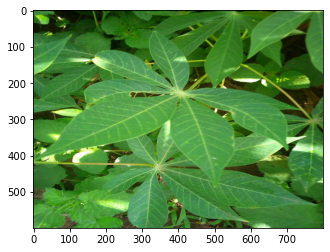

Cassava Brown Streak Disease (CBSD)


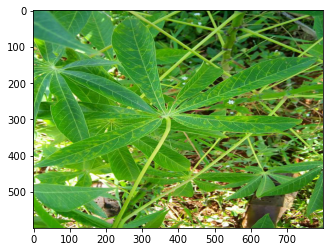

Cassava Mosaic Disease (CMD)


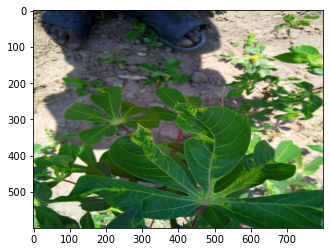

Cassava Mosaic Disease (CMD)


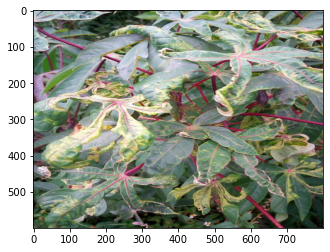

Cassava Green Mottle (CGM)


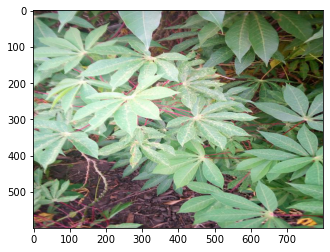

Cassava Bacterial Blight (CBB)


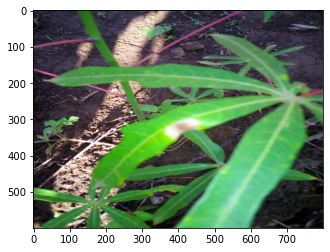

Healthy


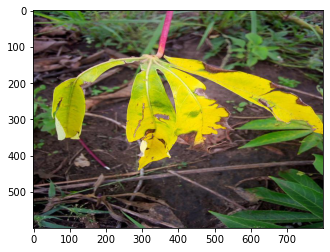

Cassava Mosaic Disease (CMD)


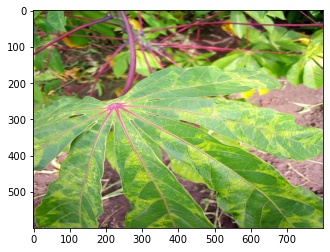

In [63]:
names_lst = os.listdir(TRAIN_PATH)
labels = train_df['label']
for n in range(10):
    test_im = cv2.imread(os.path.join(TRAIN_PATH,(names_lst[n])))
    label_code = train_df['label'][n]
    print(label_names[str(label_code)])
    plt.imshow(cv2.cvtColor(test_im, cv2.COLOR_BGR2RGB))
    plt.show()

In [64]:
train_generator = ImageDataGenerator(rotation_range=270, rescale=1./255, height_shift_range=0.4, width_shift_range=0.2, zoom_range=0.3, horizontal_flip=True, vertical_flip=True, validation_split=0.2)
test_generator = ImageDataGenerator(rotation_range=270, height_shift_range=0.1, width_shift_range=0.2, horizontal_flip=True, validation_split=0.2)

In [65]:
IMG_SIZE = 224
train_gen = ImageDataGenerator(
                                    #featurewise_center=False,                                    
                                    #samplewise_center=False,
                                    #featurewise_std_normalization=False,
                                    #samplewise_std_normalization=False, 
                                    #zca_whitening=False,
                                    #zca_epsilon=1e-06,
                                    rotation_range=270,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    brightness_range=[0.1,0.9],
                                    shear_range=25,
                                    zoom_range=0.3,
                                    channel_shift_range=0.2,
                                    #fill_mode="nearest",
                                    #cval=0.0,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    #rescale=None,
                                    #preprocessing_function=None,
                                    #data_format=None,
                                    validation_split=0.2,
                                    #dtype=None,
) \
        .flow_from_dataframe(
                            train_df,
                            directory = TRAIN_PATH,
                            x_col = "image_id",
                            y_col = "label",
                            #weight_col = None,
                            target_size = (IMG_SIZE, IMG_SIZE),
                            #color_mode = "rgb",
                            #classes = None,
                            class_mode = "categorical",
                            batch_size = 32,
                            shuffle = True,
                            #seed = 34,
                            #save_to_dir = None,
                            #save_prefix = "",
                            #save_format = "png",
                            subset = "training",
                            #interpolation = "nearest",
                            #validate_filenames = True
)




valid_gen = ImageDataGenerator(
                                    validation_split = 0.2
) \
        .flow_from_dataframe(
                            train_df,
                            directory = TRAIN_PATH,
                            x_col = "image_id",
                            y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
                            class_mode = "categorical",
                            batch_size = 32,
                            shuffle = True,
                            #seed = 34,
                            subset = "validation")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [66]:
x_data = train_generator.flow_from_dataframe(train_df,TRAIN_PATH, x_col='image_id', y_col='label', target_size=(224,224), class_mode='categorical', batch_size=16,shuffle=True,subset='training')
x_data_val = test_generator.flow_from_dataframe(train_df,TRAIN_PATH, x_col='image_id', y_col='label', target_size=(224,224), class_mode='categorical', batch_size=16, shuffle=True,subset='validation')


Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [67]:
train_df.shape

(21397, 2)

In [68]:
from tensorflow.keras.layers import Layer, Conv2D,Dropout, Flatten,MaxPooling2D, MaxPool2D,UpSampling2D, Activation, add, multiply, Lambda, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [69]:
from tensorflow.keras.applications import EfficientNetB0

In [70]:
def AttnBlock2D(x, g, inter_channel, data_format='channels_first'):

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)

    f = Activation('relu')(add([theta_x, phi_g]))

    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x


def attention_up_and_concate(down_layer, layer, data_format='channels_first'):
    
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]
    
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)
    layer = AttnBlock2D(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[3]], axis=3))
    
    concate = my_concat([up, layer])
    return concate



In [71]:
# Attention U-Net 
def att_unet(img_w, img_h, n_label, data_format='channels_first'):
    inputs = Input((3, img_w, img_h))
    x = inputs
    depth = 4
    features = 32
    skips = []
    for i in range(depth):

        # ENCODER
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format='channels_first')(x)
#         x = GlobalAveragePooling2D()(x)
        features = features * 2

    # BOTTLENECK
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    # DECODER
    for i in reversed(range(depth)):
        features = features // 2
        x = attention_up_and_concate(x, skips[i], data_format=data_format)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
    
    conv6 = Conv2D(5, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = GlobalAveragePooling2D()(conv6)           #Activation('softmax')(conv6)
    out = Dense(5, activation='softmax')(conv7)
    
    model = Model(inputs=inputs, outputs=out)

    return model

In [72]:
def onionModel(height, width, depth, classes):
    model = Sequential()
    input_shape = (height, width, depth)
    chanDim = -1
    #layer1
    model.add(Conv2D(8, (5, 5), padding="same",input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #layer2
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    #layer3
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

#     model.add(Flatten())
#     model.add(Dense(128))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model

def createModel(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

#     model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
# #     model.add(Dropout(0.25))
  
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
  
    return model

In [73]:
effnet = EfficientNetB0(include_top=True, classes=5, weights=None, input_shape=(224,224,3))
effnet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

In [74]:
# model = att_unet(224, 224, n_label=1)
# model = createModel(5)
# model.summary()
model=effnet

In [75]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

In [76]:
LR_Reduce_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto')
EarlyStop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=30)
LR_Reduce_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, mode='auto')
model_ckpt1 = ModelCheckpoint('cassava_leaf_seg_model.h5', monitor='val_loss', save_weights_only=True,save_best_only=True, period=1)

bs = 16
model_ckpt2 = ModelCheckpoint('cassava_leaf_seg_model_weights.h5', monitor='val_loss', save_weights_only=False,save_best_only=True, period=1)

In [ ]:
history = model.fit(train_gen,steps_per_epoch=(train_df.shape[0]//bs), validation_data=valid_gen, 
                             epochs=10, callbacks = [model_ckpt1,model_ckpt2,EarlyStop,LR_Reduce_callback])

Epoch 1/10
 347/1337 [======>.......................] - ETA: 1:19:41 - loss: 1.7616 - acc: 0.5831